[[0.98369673 0.96911895 0.83119477]]


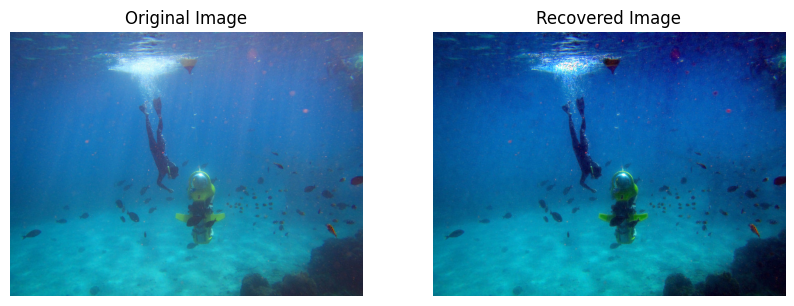

[[0.98564255 0.993963   0.7734349 ]]


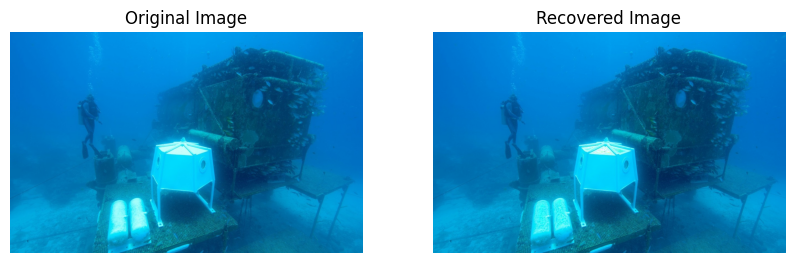

[[0.76447595 0.7758319  0.56834643]]


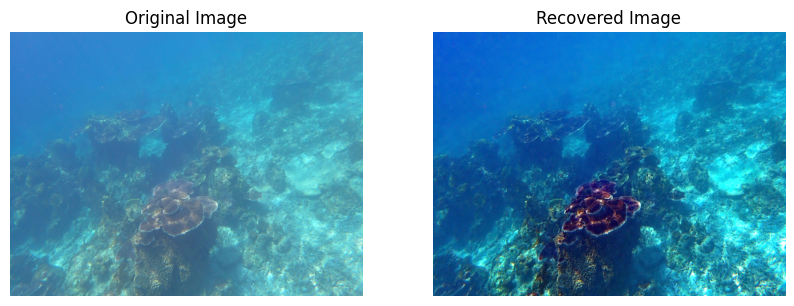

[[0.85932513 0.91552342 0.59114064]]


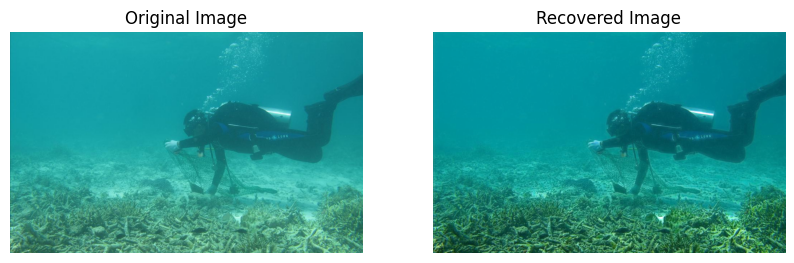

[[0.77321326 0.76434821 0.80768985]]


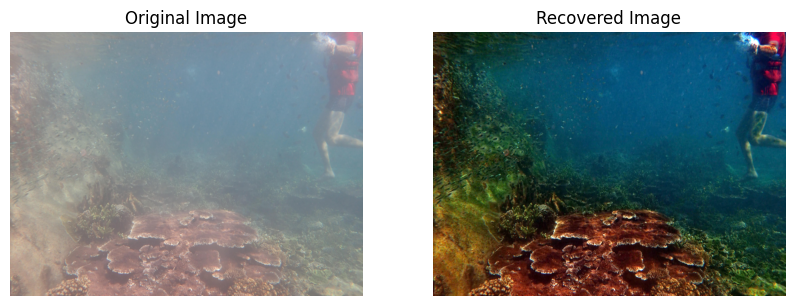

[[0.97367882 0.98205412 0.88820664]]


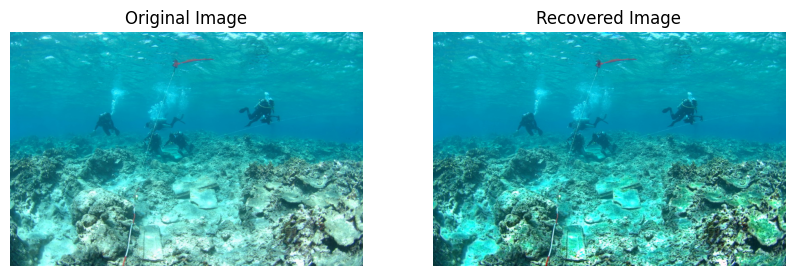

[[0.5925784  0.88177812 0.58205276]]


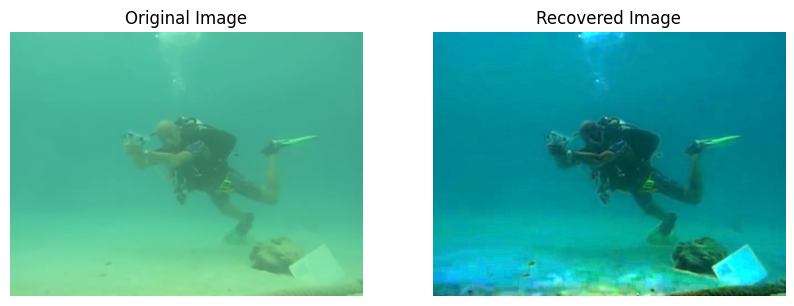

[[0.54155499 0.92918354 0.89856246]]


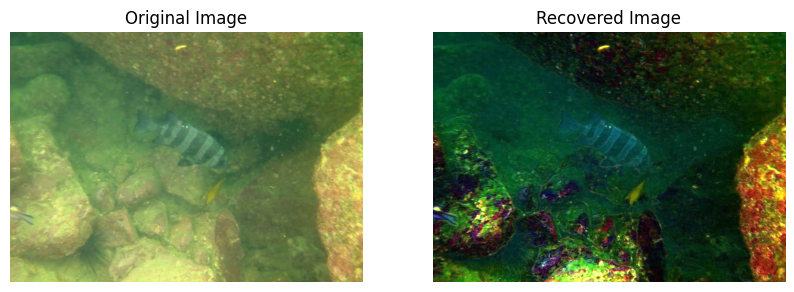

[[0.78462829 0.90957324 0.81396666]]


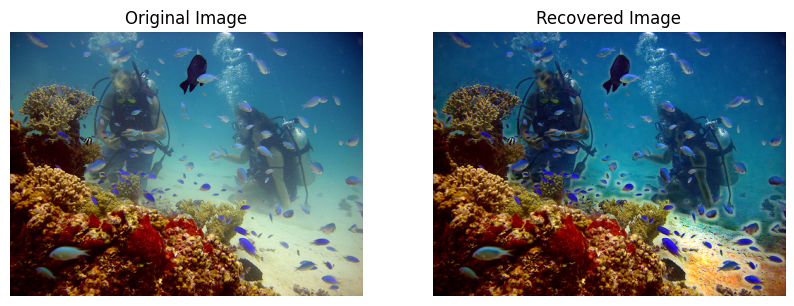

In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import os

def DarkChannel(im):
    b, g, r = cv2.split(im)
    dc = cv2.min(cv2.min(r, g), b)
    kernel = np.ones((7, 7), np.uint8)
    dark = cv2.erode(dc, kernel)
    return dark

def AtmLight(im, dark):
    [h, w] = im.shape[:2]
    imsz = h * w
    numpx = int(max(math.floor(imsz / 1000), 1))
    darkvec = dark.reshape(imsz)
    imvec = im.reshape(imsz, 3)

    indices = darkvec.argsort()
    indices = indices[imsz - numpx::]

    atmsum = np.zeros([1, 3])
    for ind in range(1, numpx):
        atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx
    return A



def TransmissionEstimate(im, A):
    im3 = np.empty(im.shape, im.dtype)
    for ind in range(0, 3):
        im3[:, :, ind] = im[:, :, ind] / A[0, ind]
    transmission = 1 -  DarkChannel(im3)
    return transmission

def Guidedfilter(im, p, r, eps):
    mean_I = cv2.GaussianBlur(im,(r, r),1)
    mean_p = cv2.GaussianBlur(p, (r, r),1)
    mean_Ip = cv2.GaussianBlur(im * p, (r, r),1)
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.GaussianBlur(im * im,(r, r),1)
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.GaussianBlur(a,(r, r),1)
    mean_b = cv2.GaussianBlur(b,(r, r),1)

    q = mean_a * im + mean_b
    return q

def TransmissionRefine(im, et):
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    gray = np.float64(gray) / 255
    r = 61
    eps = 0.0001
    t = Guidedfilter(gray, et, r, eps)

    return t

def Recover(im, t, A, tx=0.1):
    res = np.empty(im.shape, im.dtype)
    t = cv2.max(t, tx)

    for ind in range(0, 3):
        res[:, :, ind] = (im[:, :, ind] - A[0, ind]) / t + A[0, ind]

    return res


# folder_path = "C://College Projects//Applied LA for ML//5426a351-39e9-478c-8775-5fbcd69d30e5//raw//raw-890"
folder_path = "C://College Projects//Applied LA for ML//Images_for_DCP"



for filename in os.listdir(folder_path):
    if filename.endswith(".png") or filename.endswith(".jpeg") or filename.endswith(".jpg"):  # Adjust based on the file types in your folder
        file_path = os.path.join(folder_path, filename)
        
        # Load the image
        src = cv2.imread(file_path)
        # fn = 'C:/College Projects/Applied LA for ML/5426a351-39e9-478c-8775-5fbcd69d30e5/raw/raw-890/927_img_.png'
        # fn='C://College Projects//Applied LA for ML//5426a351-39e9-478c-8775-5fbcd69d30e5//raw//raw-890//11398.png'
        # src = cv2.imread(fn)

        I = src.astype('float64') / 255

        dark = DarkChannel(I)
        A = AtmLight(I, dark)
        print(A)
        te = TransmissionEstimate(I, A)
        t = TransmissionRefine(src, te)
        J = Recover(I, t, A, 0.1)


        plt.figure(figsize=(10, 10))

        # Dark Channel
        # plt.subplot(2, 2, 1)
        # plt.imshow(dark, cmap='gray')
        # plt.title('Dark Channel')
        # plt.axis('off')

        # # Transmission
        # plt.subplot(2, 2, 2)
        # plt.imshow(t, cmap='gray')
        # plt.title('Transmission')
        # plt.axis('off')

        # Original Image
        plt.subplot(2, 2, 1)
        plt.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        # Recovered Image
        plt.subplot(2, 2, 2)
        J_display = np.clip(J, 0, 1)
        J_display_uint8 = (J_display * 255).astype(np.uint8)
        J_rgb = cv2.cvtColor(J_display_uint8, cv2.COLOR_BGR2RGB)
        plt.imshow(J_rgb)
        plt.title('Recovered Image')
        plt.axis('off')

        # plt.tight_layout()
        plt.show()
        # cv2.imwrite("output.png", J * 255)
